
<div class="note">
    <p style="margin-top: 0; margin-bottom: 0;">
        <img style="margin-top: 0; margin-bottom: 0; height: 2em;" class="inline-block mr-2 no-fancybox"
            src="https://upload.wikimedia.org/wikipedia/commons/3/38/Jupyter_logo.svg" alt="">
        This page is based on a Jupyter notebook.
<a href="./SimpleMechanics.ipynb" download="SimpleMechanics.ipynb"><img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" src="https://img.shields.io/static/v1?label=Download:&message=SimpleMechanics.ipynb&color=blue" /></a>
<a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/Mechanics/Linear/SimpleMechanics.py"><img src="https://img.shields.io/static/v1?label=Source:&message=SimpleMechanics.py&color=brightgreen" class="no-fancybox"
        style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" /></a>
<a href="https://binder.opengeosys.org/v2/gh/bilke/binder-ogs-requirements/master?urlpath=git-pull%3Frepo=https://gitlab.opengeosys.org/ogs/ogs%26urlpath=lab/tree/ogs/Tests/Data/Mechanics/Linear/SimpleMechanics.py%26branch=master%26depth=1">
    <img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;"
        src="https://img.shields.io/static/v1?label=&message=Launch notebook&color=5c5c5c&logo=" />
</a></p></div>

The following example consists of a simple mechanics problem.

In [1]:
import os
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import ogstools as ot

In [2]:
out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
if not out_dir.exists():
    out_dir.mkdir(parents=True)

In [3]:
prj_name = "SimpleMechanics"
model = ot.Project(output_file=(out_dir / f"{prj_name}.prj"))
model.geometry.add_geometry(filename="./square_1x1.gml")
model.mesh.add_mesh(filename="./square_1x1_quad_1e2.vtu")
model.processes.set_process(
    name="SD",
    type="SMALL_DEFORMATION",
    integration_order="2",
    specific_body_force="0 0",
)
model.processes.set_constitutive_relation(
    type="LinearElasticIsotropic", youngs_modulus="E", poissons_ratio="nu"
)
model.processes.add_process_variable(
    process_variable="process_variable", process_variable_name="displacement"
)
model.processes.add_secondary_variable(internal_name="sigma", output_name="sigma")
model.time_loop.add_process(
    process="SD",
    nonlinear_solver_name="basic_newton",
    convergence_type="DeltaX",
    norm_type="NORM2",
    abstol="1e-15",
    time_discretization="BackwardEuler",
)
model.time_loop.set_stepping(
    process="SD",
    type="FixedTimeStepping",
    t_initial="0",
    t_end="1",
    repeat="4",
    delta_t="0.25",
)
model.time_loop.add_output(
    type="VTK",
    prefix=prj_name,
    repeat="1",
    each_steps="4",
    variables=["displacement", "sigma"],
)
model.media.add_property(
    medium_id="0", phase_type="Solid", name="density", type="Constant", value="1"
)
model.parameters.add_parameter(name="E", type="Constant", value="1")
model.parameters.add_parameter(name="nu", type="Constant", value="0.3")
model.parameters.add_parameter(name="displacement0", type="Constant", values="0 0")
model.parameters.add_parameter(name="dirichlet0", type="Constant", value="0")
model.parameters.add_parameter(name="dirichlet1", type="Constant", value="0.05")
model.process_variables.set_ic(
    process_variable_name="displacement",
    components="2",
    order="1",
    initial_condition="displacement0",
)
model.process_variables.add_bc(
    process_variable_name="displacement",
    geometrical_set="square_1x1_geometry",
    geometry="left",
    type="Dirichlet",
    component="0",
    parameter="dirichlet0",
)
model.process_variables.add_bc(
    process_variable_name="displacement",
    geometrical_set="square_1x1_geometry",
    geometry="bottom",
    type="Dirichlet",
    component="1",
    parameter="dirichlet0",
)
model.process_variables.add_bc(
    process_variable_name="displacement",
    geometrical_set="square_1x1_geometry",
    geometry="top",
    type="Dirichlet",
    component="1",
    parameter="dirichlet1",
)
model.nonlinear_solvers.add_non_lin_solver(
    name="basic_newton",
    type="Newton",
    max_iter="4",
    linear_solver="general_linear_solver",
)
model.linear_solvers.add_lin_solver(
    name="general_linear_solver",
    kind="lis",
    solver_type="cg",
    precon_type="jacobi",
    max_iteration_step="10000",
    error_tolerance="1e-16",
)
model.linear_solvers.add_lin_solver(
    name="general_linear_solver",
    kind="eigen",
    solver_type="CG",
    precon_type="DIAGONAL",
    max_iteration_step="10000",
    error_tolerance="1e-16",
)
model.linear_solvers.add_lin_solver(
    name="general_linear_solver",
    kind="petsc",
    prefix="sd",
    solver_type="cg",
    precon_type="bjacobi",
    max_iteration_step="10000",
    error_tolerance="1e-16",
)
try:
    model.write_input()
    model.run_model(
        logfile=(out_dir / f"{prj_name}-out.txt"), args=f"-o {out_dir} -m ."
    )
except Exception as inst:
    print(f"{type(inst)}: {inst.args[0]}")

print(datetime.now())

OGS finished with project file /var/lib/gitlab-runner/builds/geF4QCR1Z/0/ogs/build/release-all/Tests/Data/Mechanics/Linear/SimpleMechanics/SimpleMechanics.prj.
Execution took 0.14110589027404785 s
Project file written to output.
2025-04-11 09:32:54.820893


In [4]:
ms = ot.MeshSeries(f"{out_dir}/{prj_name}.pvd").scale(time=("s", "a"))
points_coords = np.array([[0.3, 0.5, 0.0], [0.24, 0.21, 0.0]])
points_labels = ["pt0", "pt1"]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 1176.85it/s]

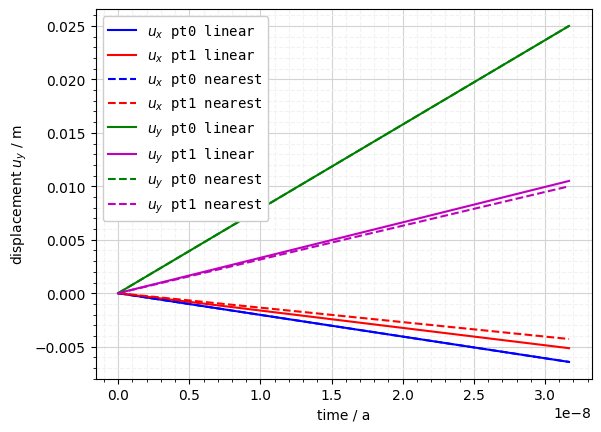

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1)

colors = {"x": ["b", "r"], "y": ["g", "m"]}
linestyles = {"linear": ["-", "-"], "nearest": ["--", "--"]}

for component in ["x", "y"]:
    for interp_method in ["linear", "nearest"]:
        labels = [f"$u_{component}$ {label} {interp_method}" for label in points_labels]

        ms.plot_probe(
            points_coords,
            ot.variables.displacement[component],
            labels=labels,
            interp_method=interp_method,
            ax=fig.axes[0],
            colors=colors[component],
            linestyles=linestyles[interp_method],
        )